In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 50

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -5
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 10

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}


In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 0.15 # exploration rate
        self.epsilon_min = 0.15
        self.epsilon_decay = 0.9997
        
        self.learning_rate = 0.0008471
        self.learning_rate_decay = 0.99999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))

        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > 80 * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0.00001
    NEGATIVE_TIMES_REWARD = 0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS * TIMES_FACTOR
            self.closed_counter += reward / TIMES_FACTOR
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS * TIMES_FACTOR
            self.closed_counter += reward / TIMES_FACTOR
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

C:\Users\Lukas\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
More than 80 on candle 491
More than 80 on candle 1648


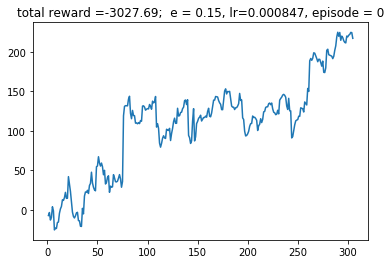

Waiting to train the whole dataset
DONE, lets roll!!
156.804
More than 80 on candle 493
More than 80 on candle 854
More than 80 on candle 1654


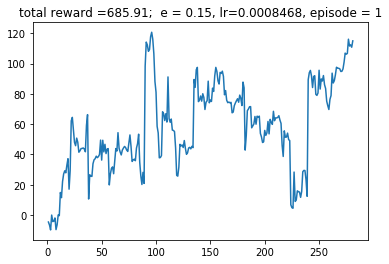

Waiting to train the whole dataset
DONE, lets roll!!
145.407
More than 80 on candle 500


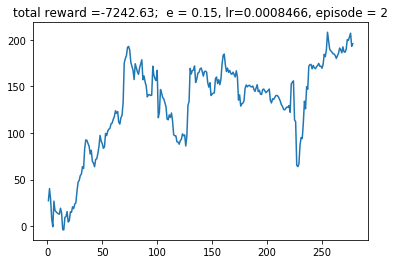

Waiting to train the whole dataset
DONE, lets roll!!
145.661
More than 80 on candle 476
More than 80 on candle 1639
More than 80 on candle 1663


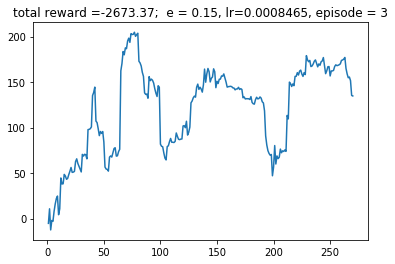

Waiting to train the whole dataset
DONE, lets roll!!
146.89
More than 80 on candle 188
More than 80 on candle 496


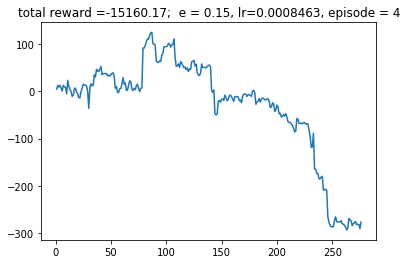

Waiting to train the whole dataset
DONE, lets roll!!
145.261
More than 80 on candle 484
More than 80 on candle 1554


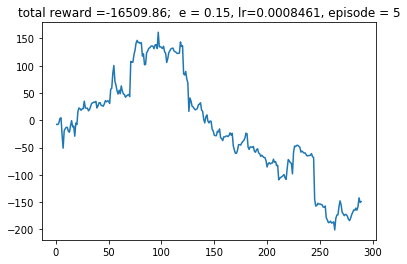

Waiting to train the whole dataset
DONE, lets roll!!
144.532
More than 80 on candle 96
More than 80 on candle 293
More than 80 on candle 494
More than 80 on candle 1566


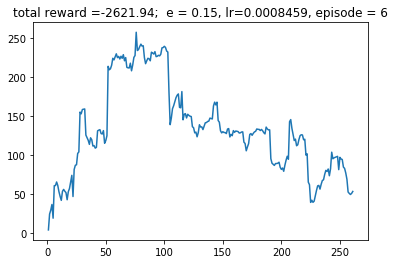

Waiting to train the whole dataset
DONE, lets roll!!
145.055
More than 80 on candle 92
More than 80 on candle 478
More than 80 on candle 1640


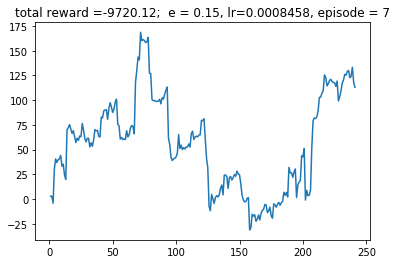

Waiting to train the whole dataset
DONE, lets roll!!
145.007
More than 80 on candle 101
More than 80 on candle 1547
More than 80 on candle 1646


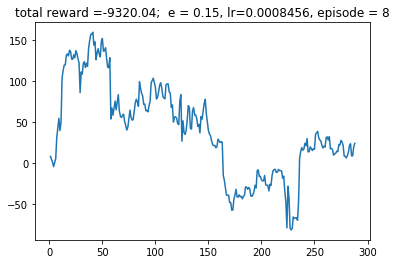

Waiting to train the whole dataset
DONE, lets roll!!
145.498
More than 80 on candle 291
More than 80 on candle 520


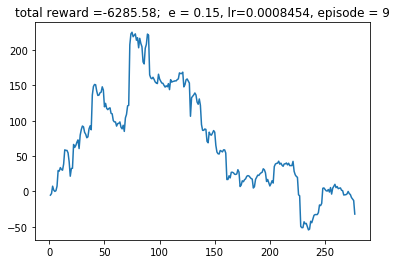

Waiting to train the whole dataset
DONE, lets roll!!
145.467
More than 80 on candle 194
More than 80 on candle 474
More than 80 on candle 665
More than 80 on candle 1647


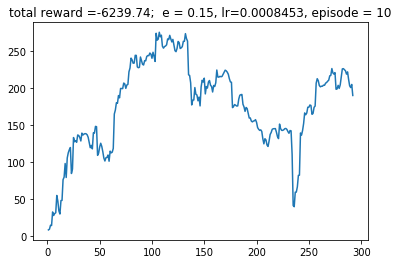

Waiting to train the whole dataset
DONE, lets roll!!
145.775
More than 80 on candle 106
More than 80 on candle 189
More than 80 on candle 475
More than 80 on candle 1637
More than 80 on candle 1651


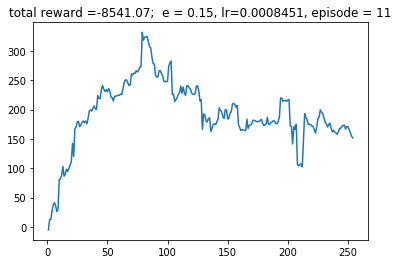

Waiting to train the whole dataset
DONE, lets roll!!
146.28
More than 80 on candle 37
More than 80 on candle 108
More than 80 on candle 479
More than 80 on candle 1666


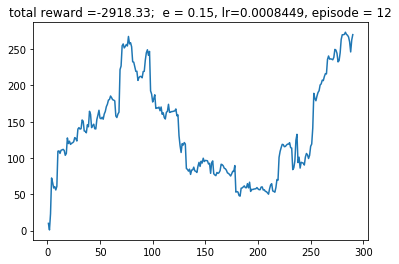

Waiting to train the whole dataset
DONE, lets roll!!
145.678
More than 80 on candle 90
More than 80 on candle 183
More than 80 on candle 475
More than 80 on candle 665
More than 80 on candle 849
More than 80 on candle 1648


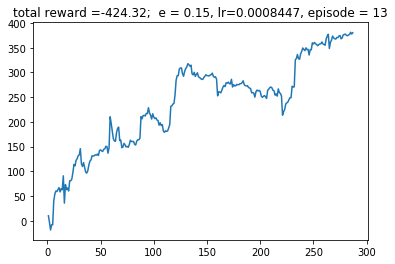

Waiting to train the whole dataset
DONE, lets roll!!
145.317
More than 80 on candle 186
More than 80 on candle 478
More than 80 on candle 875


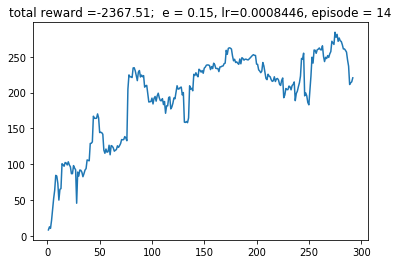

Waiting to train the whole dataset
DONE, lets roll!!
147.151
More than 80 on candle 92
More than 80 on candle 477


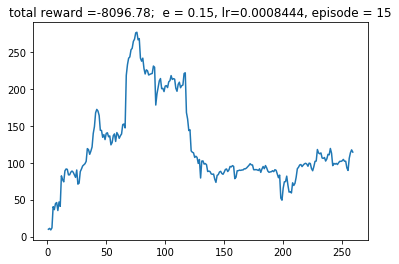

Waiting to train the whole dataset
DONE, lets roll!!
144.946
More than 80 on candle 85
More than 80 on candle 289
More than 80 on candle 478
More than 80 on candle 1528
More than 80 on candle 1559


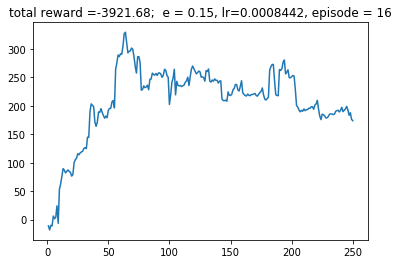

Waiting to train the whole dataset
DONE, lets roll!!
145.303
More than 80 on candle 197
More than 80 on candle 477


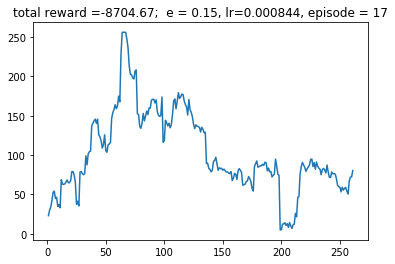

Waiting to train the whole dataset
DONE, lets roll!!
145.196
More than 80 on candle 95
More than 80 on candle 480
More than 80 on candle 882
More than 80 on candle 1163
More than 80 on candle 1641


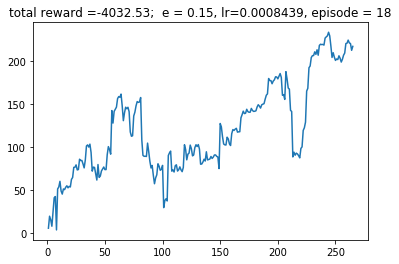

Waiting to train the whole dataset
DONE, lets roll!!
144.997
More than 80 on candle 86
More than 80 on candle 501
More than 80 on candle 874


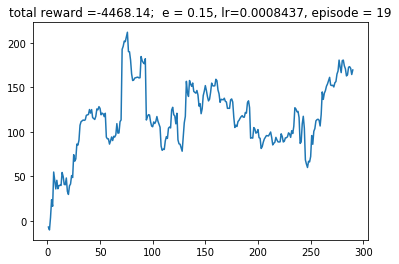

Waiting to train the whole dataset
DONE, lets roll!!
145.837
More than 80 on candle 480


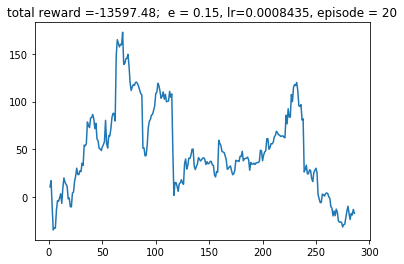

Waiting to train the whole dataset
DONE, lets roll!!
146.964
More than 80 on candle 91
More than 80 on candle 1169
More than 80 on candle 1562
More than 80 on candle 1659


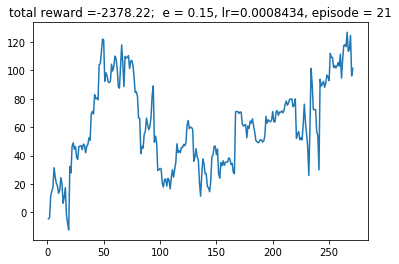

Waiting to train the whole dataset
DONE, lets roll!!
145.758
More than 80 on candle 498
More than 80 on candle 1648


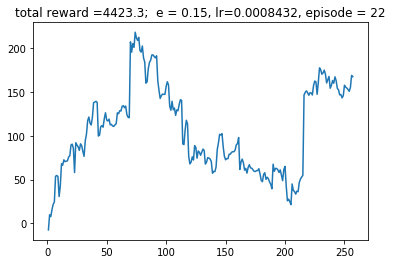

Waiting to train the whole dataset
DONE, lets roll!!
145.945
More than 80 on candle 90
More than 80 on candle 198
More than 80 on candle 480
More than 80 on candle 1547
More than 80 on candle 1656


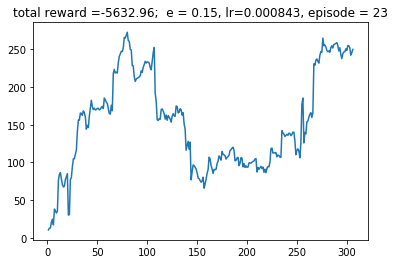

Waiting to train the whole dataset
DONE, lets roll!!
154.662
More than 80 on candle 191
More than 80 on candle 317
More than 80 on candle 479
More than 80 on candle 1666


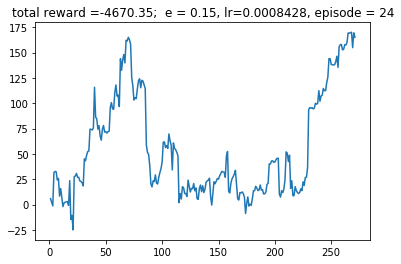

Waiting to train the whole dataset
DONE, lets roll!!
153.821
More than 80 on candle 690
More than 80 on candle 886
More than 80 on candle 1563


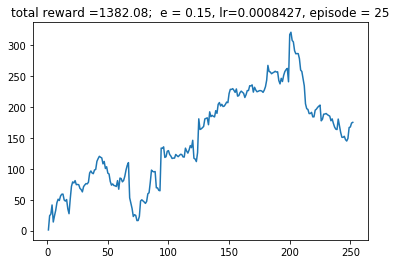

Waiting to train the whole dataset
DONE, lets roll!!
148.156
More than 80 on candle 482
More than 80 on candle 1544
More than 80 on candle 1656


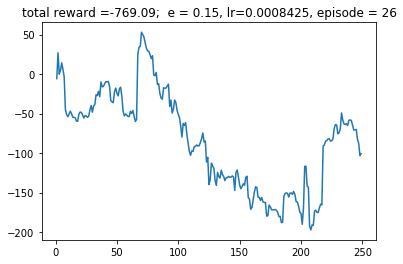

Waiting to train the whole dataset
DONE, lets roll!!
148.313
More than 80 on candle 86
More than 80 on candle 185
More than 80 on candle 476
More than 80 on candle 1647


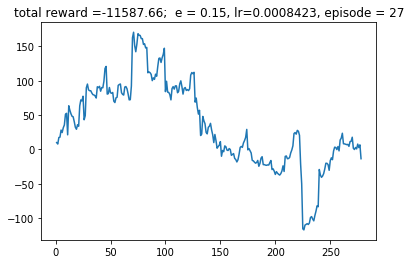

Waiting to train the whole dataset
DONE, lets roll!!
148.387
More than 80 on candle 35
More than 80 on candle 190
More than 80 on candle 479
More than 80 on candle 879
More than 80 on candle 1162
More than 80 on candle 1531
More than 80 on candle 1647


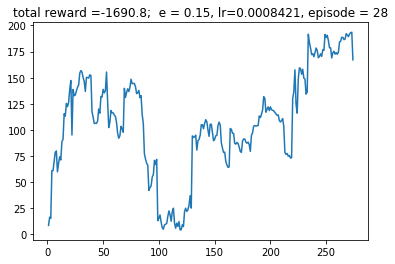

Waiting to train the whole dataset
DONE, lets roll!!
145.458
More than 80 on candle 261
More than 80 on candle 480
More than 80 on candle 1639


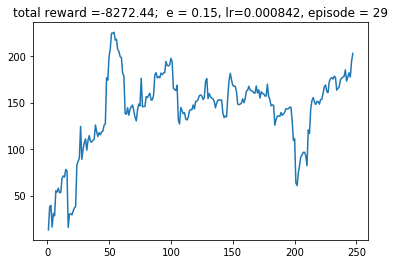

Waiting to train the whole dataset
DONE, lets roll!!
146.179
More than 80 on candle 190
More than 80 on candle 491
More than 80 on candle 1550
More than 80 on candle 1644


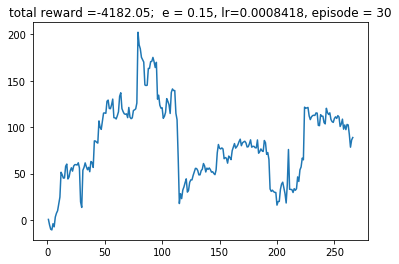

Waiting to train the whole dataset
DONE, lets roll!!
145.174
More than 80 on candle 45
More than 80 on candle 479
More than 80 on candle 1654


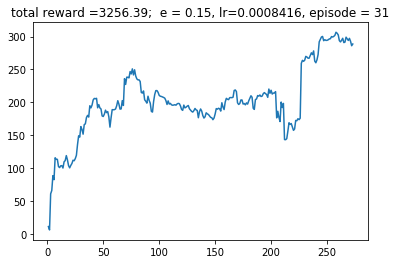

Waiting to train the whole dataset
DONE, lets roll!!
145.305
More than 80 on candle 102
More than 80 on candle 874
More than 80 on candle 1651


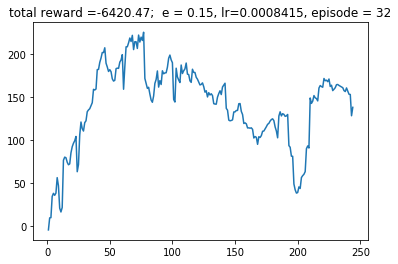

Waiting to train the whole dataset
DONE, lets roll!!
145.231
More than 80 on candle 90
More than 80 on candle 474
More than 80 on candle 1653


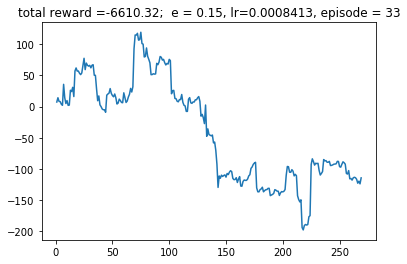

Waiting to train the whole dataset
DONE, lets roll!!
144.718
More than 80 on candle 92
More than 80 on candle 185
More than 80 on candle 475
More than 80 on candle 1640


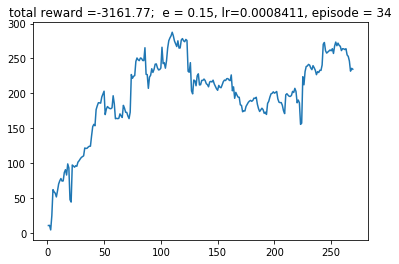

Waiting to train the whole dataset
DONE, lets roll!!
145.157
More than 80 on candle 187
More than 80 on candle 474
More than 80 on candle 1702


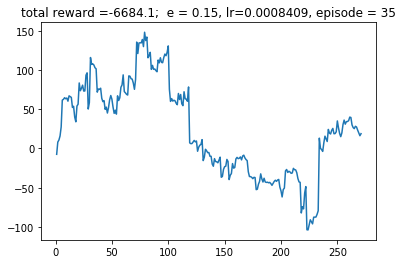

Waiting to train the whole dataset
DONE, lets roll!!
145.544
More than 80 on candle 481


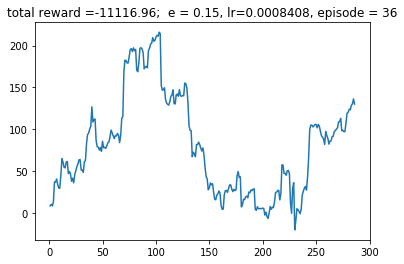

Waiting to train the whole dataset
DONE, lets roll!!
144.794
More than 80 on candle 479
More than 80 on candle 1646


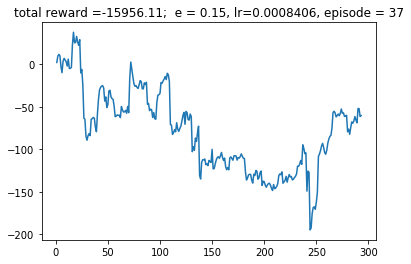

Waiting to train the whole dataset
DONE, lets roll!!
144.51
More than 80 on candle 85
More than 80 on candle 476


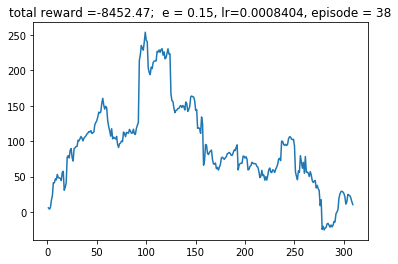

Waiting to train the whole dataset
DONE, lets roll!!
145.733
More than 80 on candle 301
More than 80 on candle 493


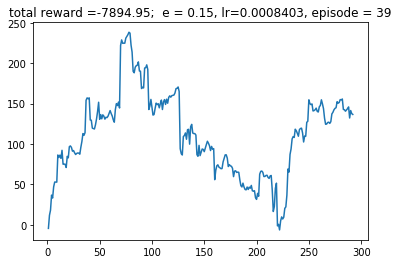

Waiting to train the whole dataset
DONE, lets roll!!
144.231
More than 80 on candle 39
More than 80 on candle 110
More than 80 on candle 262
More than 80 on candle 476
More than 80 on candle 529
More than 80 on candle 1651


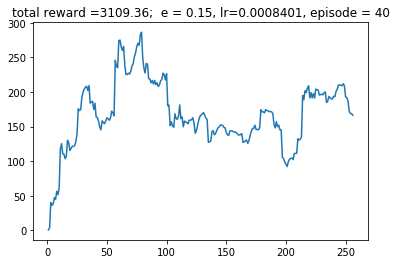

Waiting to train the whole dataset
DONE, lets roll!!
145.366
More than 80 on candle 85
More than 80 on candle 198
More than 80 on candle 501


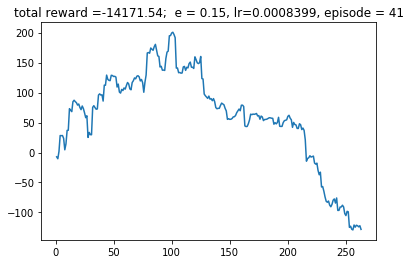

Waiting to train the whole dataset
DONE, lets roll!!
144.645
More than 80 on candle 474
More than 80 on candle 1546


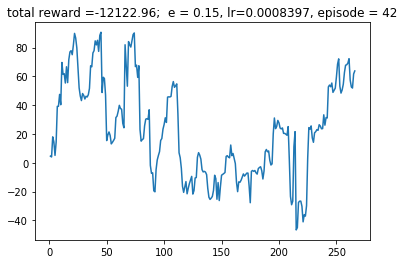

Waiting to train the whole dataset
DONE, lets roll!!
145.36
More than 80 on candle 91
More than 80 on candle 194
More than 80 on candle 492


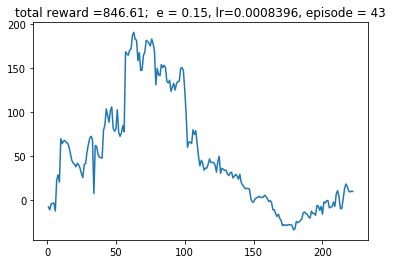

Waiting to train the whole dataset
DONE, lets roll!!
146.646
More than 80 on candle 38
More than 80 on candle 85
More than 80 on candle 477


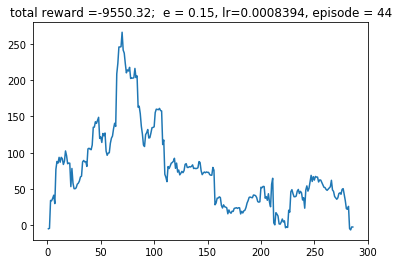

Waiting to train the whole dataset
DONE, lets roll!!
145.336
More than 80 on candle 484


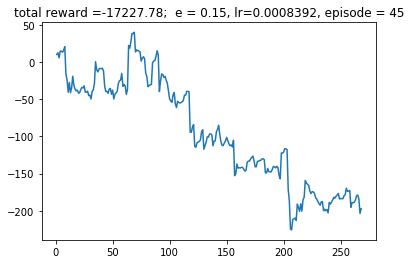

Waiting to train the whole dataset
DONE, lets roll!!
144.977
More than 80 on candle 503
More than 80 on candle 1546
More than 80 on candle 1650


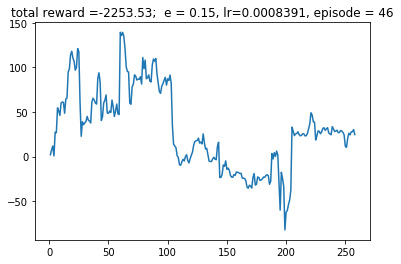

Waiting to train the whole dataset
DONE, lets roll!!
145.006
More than 80 on candle 206
More than 80 on candle 481
More than 80 on candle 1645


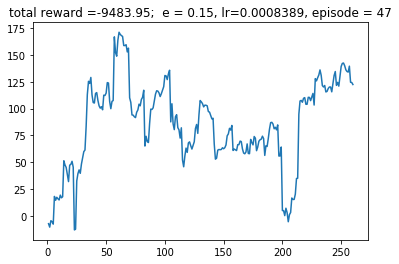

Waiting to train the whole dataset
DONE, lets roll!!
144.733
More than 80 on candle 192
More than 80 on candle 475
More than 80 on candle 1643


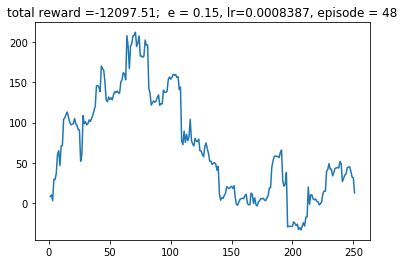

Waiting to train the whole dataset
DONE, lets roll!!
147.485
More than 80 on candle 178
More than 80 on candle 480
More than 80 on candle 1642


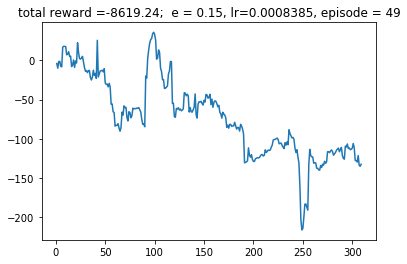

Waiting to train the whole dataset
DONE, lets roll!!
145.332
More than 80 on candle 91
More than 80 on candle 212
More than 80 on candle 494
More than 80 on candle 1549


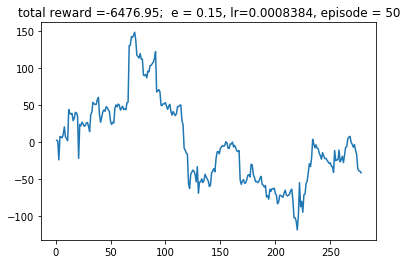

Waiting to train the whole dataset
DONE, lets roll!!
146.698
More than 80 on candle 108
More than 80 on candle 185
More than 80 on candle 477
More than 80 on candle 1548


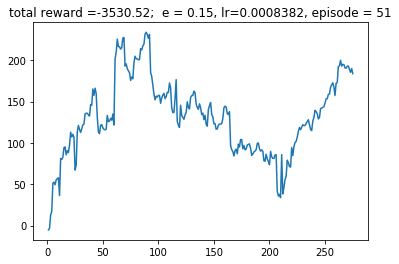

Waiting to train the whole dataset
DONE, lets roll!!
145.255
More than 80 on candle 86
More than 80 on candle 486
More than 80 on candle 1647


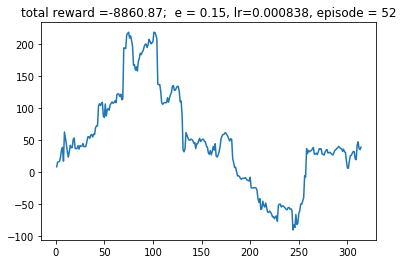

Waiting to train the whole dataset
DONE, lets roll!!
147.038
More than 80 on candle 182


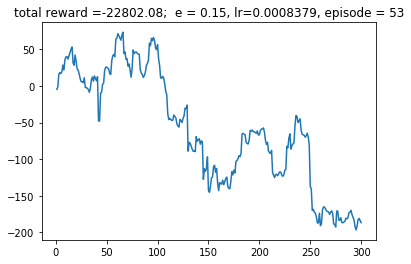

Waiting to train the whole dataset
DONE, lets roll!!
145.44
More than 80 on candle 85
More than 80 on candle 480
More than 80 on candle 1655


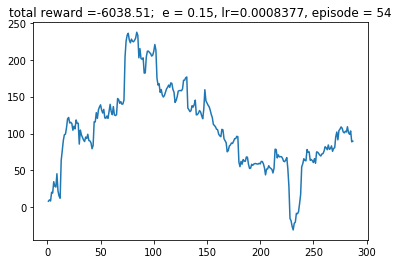

Waiting to train the whole dataset
DONE, lets roll!!
145.559
More than 80 on candle 184
More than 80 on candle 317
More than 80 on candle 486
More than 80 on candle 1655


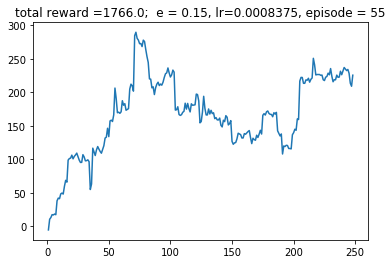

Waiting to train the whole dataset
DONE, lets roll!!
145.3
More than 80 on candle 185
More than 80 on candle 296
More than 80 on candle 491


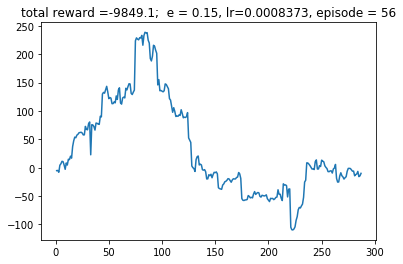

Waiting to train the whole dataset
DONE, lets roll!!
145.05
More than 80 on candle 481
More than 80 on candle 1461
More than 80 on candle 1657


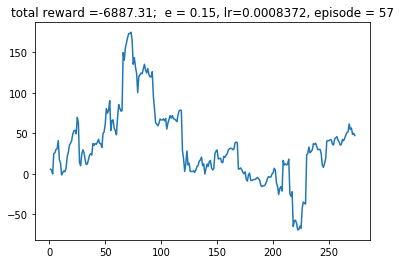

Waiting to train the whole dataset
DONE, lets roll!!
145.099
More than 80 on candle 476
More than 80 on candle 1548
More than 80 on candle 1650


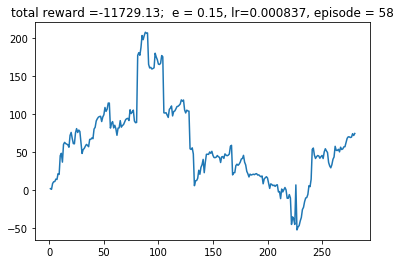

Waiting to train the whole dataset
DONE, lets roll!!
146.895
More than 80 on candle 60
More than 80 on candle 490
More than 80 on candle 1658


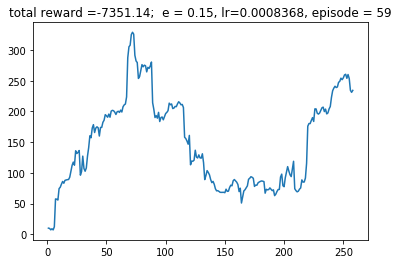

Waiting to train the whole dataset
DONE, lets roll!!
145.392
More than 80 on candle 101
More than 80 on candle 474
More than 80 on candle 1654


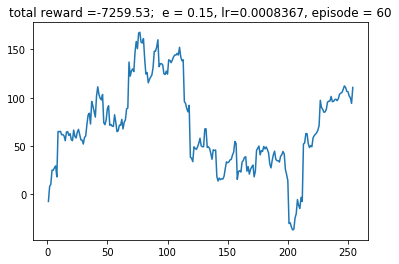

Waiting to train the whole dataset
DONE, lets roll!!
149.832
More than 80 on candle 87
More than 80 on candle 481
More than 80 on candle 1643


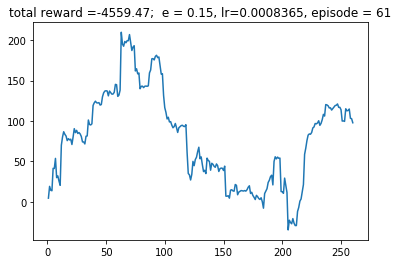

Waiting to train the whole dataset
DONE, lets roll!!
145.224
More than 80 on candle 86
More than 80 on candle 480
More than 80 on candle 1645


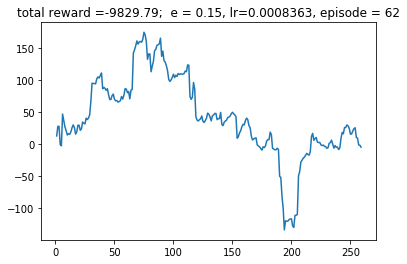

Waiting to train the whole dataset
DONE, lets roll!!
146.313
More than 80 on candle 188
More than 80 on candle 509
More than 80 on candle 1639


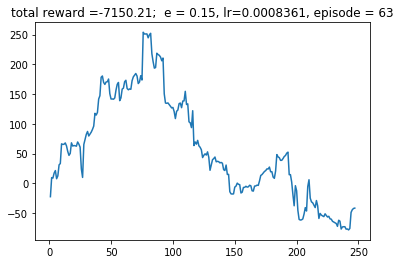

Waiting to train the whole dataset
DONE, lets roll!!
145.51
More than 80 on candle 94
More than 80 on candle 488
More than 80 on candle 1674


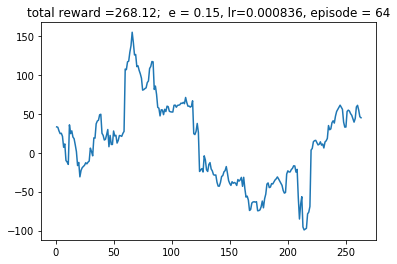

Waiting to train the whole dataset
DONE, lets roll!!
145.308
More than 80 on candle 489
More than 80 on candle 1546
More than 80 on candle 1657


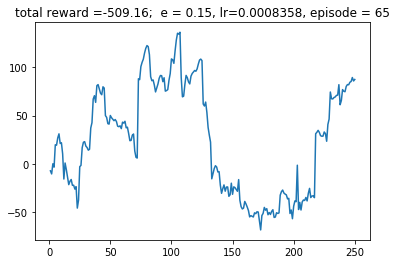

Waiting to train the whole dataset
DONE, lets roll!!
145.25
More than 80 on candle 48
More than 80 on candle 87
More than 80 on candle 192
More than 80 on candle 494
More than 80 on candle 1644


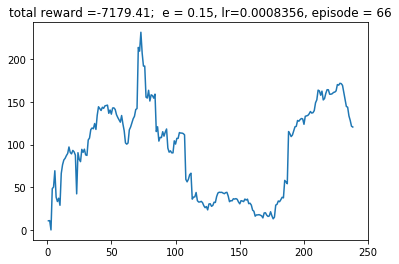

Waiting to train the whole dataset
DONE, lets roll!!
145.561
More than 80 on candle 177
More than 80 on candle 340
More than 80 on candle 482
More than 80 on candle 1646


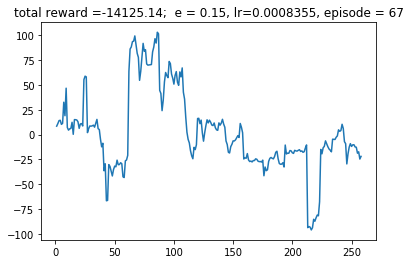

Waiting to train the whole dataset
DONE, lets roll!!
145.378
More than 80 on candle 89
More than 80 on candle 297
More than 80 on candle 483
More than 80 on candle 1162
More than 80 on candle 1662


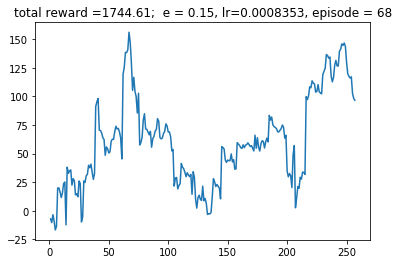

Waiting to train the whole dataset
DONE, lets roll!!
145.386
More than 80 on candle 478
More than 80 on candle 1646


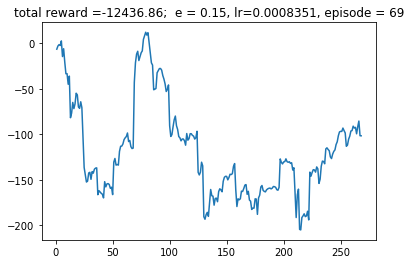

Waiting to train the whole dataset
DONE, lets roll!!
212.175
More than 80 on candle 489
More than 80 on candle 1641


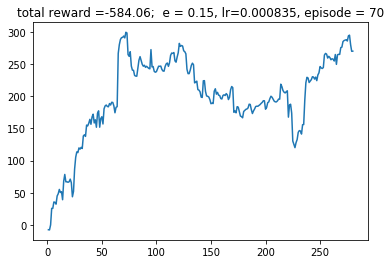

Waiting to train the whole dataset
DONE, lets roll!!
145.315
More than 80 on candle 101
More than 80 on candle 480


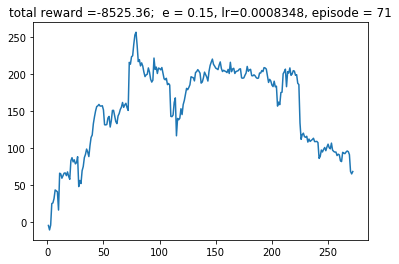

Waiting to train the whole dataset
DONE, lets roll!!
145.469
More than 80 on candle 476
More than 80 on candle 527
More than 80 on candle 1645


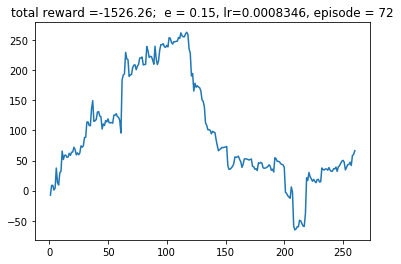

Waiting to train the whole dataset
DONE, lets roll!!
145.22
More than 80 on candle 88
More than 80 on candle 482
More than 80 on candle 1656


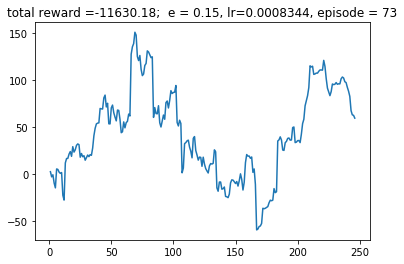

Waiting to train the whole dataset
DONE, lets roll!!
146.149
More than 80 on candle 1647


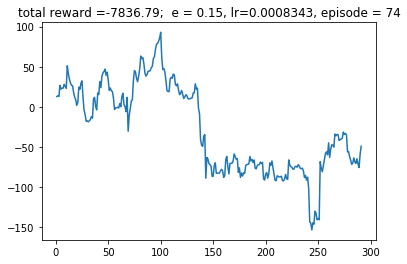

Waiting to train the whole dataset
DONE, lets roll!!
145.519
More than 80 on candle 1555


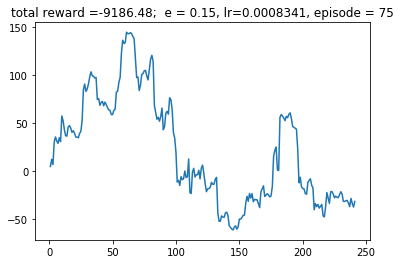

Waiting to train the whole dataset
DONE, lets roll!!
145.423
More than 80 on candle 87
More than 80 on candle 476


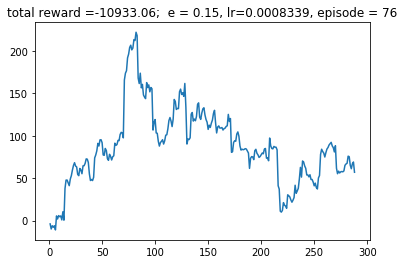

Waiting to train the whole dataset
DONE, lets roll!!
147.37
More than 80 on candle 489
More than 80 on candle 1640


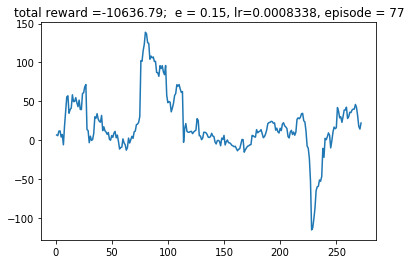

Waiting to train the whole dataset
DONE, lets roll!!
145.378
More than 80 on candle 475


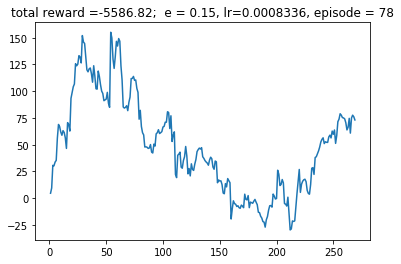

Waiting to train the whole dataset
DONE, lets roll!!
145.991
More than 80 on candle 85
More than 80 on candle 474
More than 80 on candle 1644


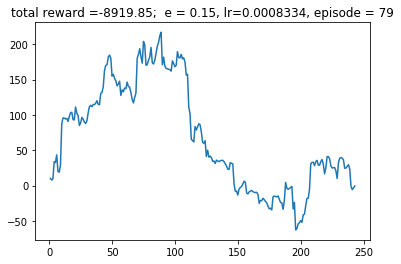

Waiting to train the whole dataset
DONE, lets roll!!
146.376
More than 80 on candle 481
More than 80 on candle 874
More than 80 on candle 1547


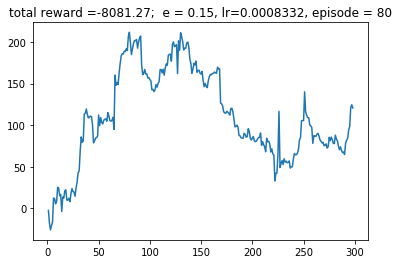

Waiting to train the whole dataset
DONE, lets roll!!
144.19
More than 80 on candle 476
More than 80 on candle 874
More than 80 on candle 1492
More than 80 on candle 1644


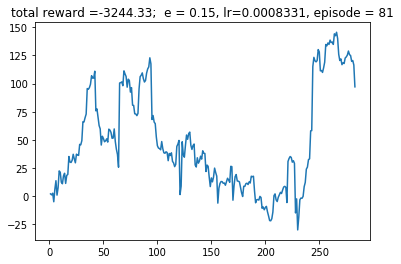

Waiting to train the whole dataset
DONE, lets roll!!
144.161
More than 80 on candle 502
More than 80 on candle 1651


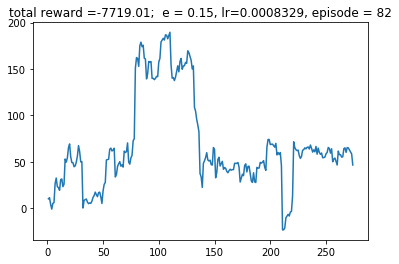

Waiting to train the whole dataset
DONE, lets roll!!
144.725
More than 80 on candle 92
More than 80 on candle 189
More than 80 on candle 483
More than 80 on candle 1649


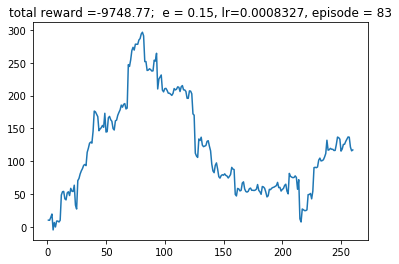

Waiting to train the whole dataset
DONE, lets roll!!
146.039
More than 80 on candle 476
More than 80 on candle 1648


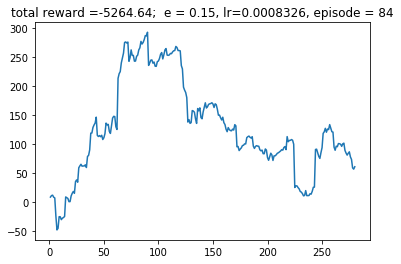

Waiting to train the whole dataset
DONE, lets roll!!
145.393
More than 80 on candle 474
More than 80 on candle 1650


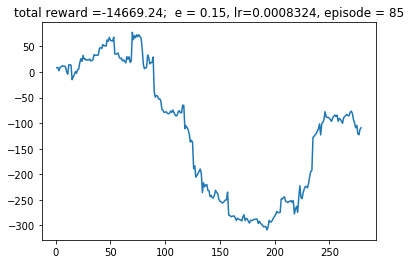

Waiting to train the whole dataset
DONE, lets roll!!
144.555
More than 80 on candle 673
More than 80 on candle 1647


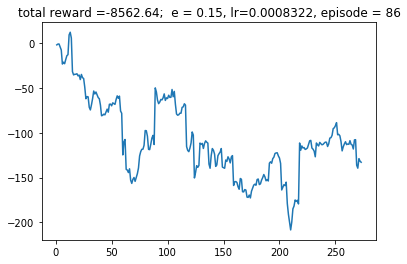

Waiting to train the whole dataset
DONE, lets roll!!
144.771
More than 80 on candle 220
More than 80 on candle 505
More than 80 on candle 1646


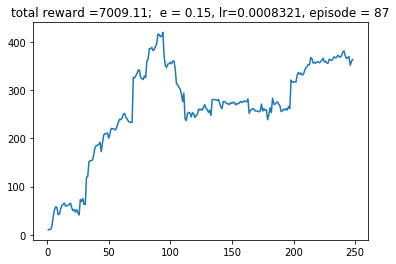

Waiting to train the whole dataset
DONE, lets roll!!
145.298
More than 80 on candle 194
More than 80 on candle 475
More than 80 on candle 1692


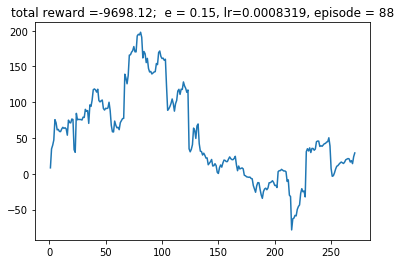

Waiting to train the whole dataset
DONE, lets roll!!
146.227
More than 80 on candle 97
More than 80 on candle 477
More than 80 on candle 874
More than 80 on candle 1556


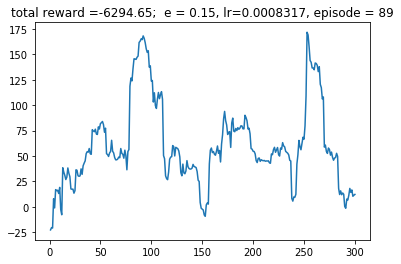

Waiting to train the whole dataset
DONE, lets roll!!
145.357
More than 80 on candle 85
More than 80 on candle 677
More than 80 on candle 1662


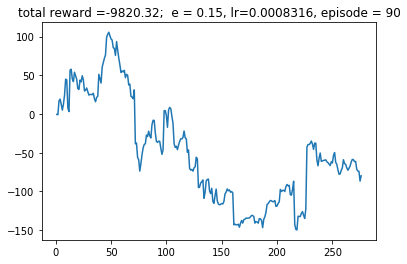

Waiting to train the whole dataset
DONE, lets roll!!
144.434
More than 80 on candle 486
More than 80 on candle 1664


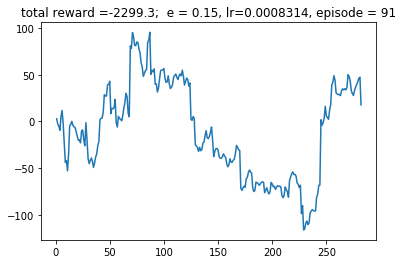

Waiting to train the whole dataset
DONE, lets roll!!
146.226
More than 80 on candle 93
More than 80 on candle 202
More than 80 on candle 475
More than 80 on candle 1647


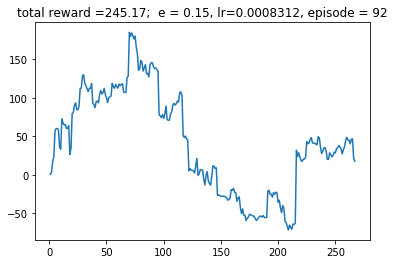

Waiting to train the whole dataset
DONE, lets roll!!
145.763
More than 80 on candle 85
More than 80 on candle 187
More than 80 on candle 287
More than 80 on candle 475
More than 80 on candle 1641


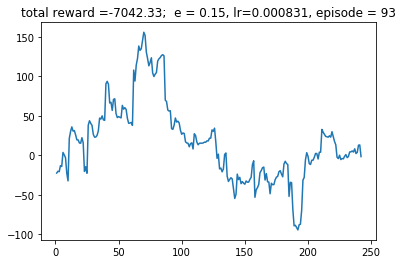

Waiting to train the whole dataset
DONE, lets roll!!
145.306
More than 80 on candle 41
More than 80 on candle 257
More than 80 on candle 309
More than 80 on candle 478


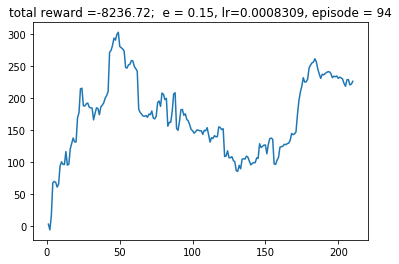

Waiting to train the whole dataset
DONE, lets roll!!
145.357
More than 80 on candle 1531


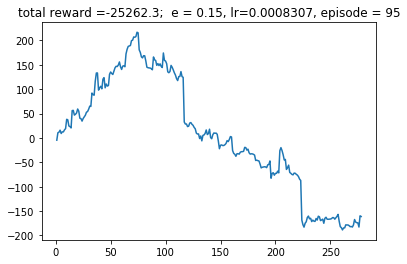

Waiting to train the whole dataset
DONE, lets roll!!
145.314
More than 80 on candle 187
More than 80 on candle 318
More than 80 on candle 483
More than 80 on candle 1643


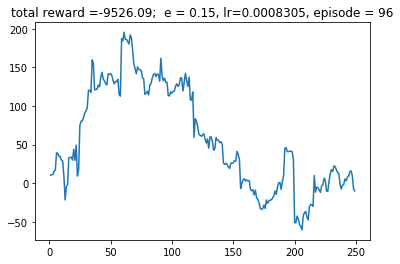

Waiting to train the whole dataset
DONE, lets roll!!
145.065
More than 80 on candle 185
More than 80 on candle 474
More than 80 on candle 1641


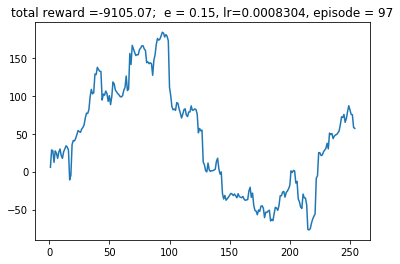

Waiting to train the whole dataset
DONE, lets roll!!
144.635
More than 80 on candle 90
More than 80 on candle 182


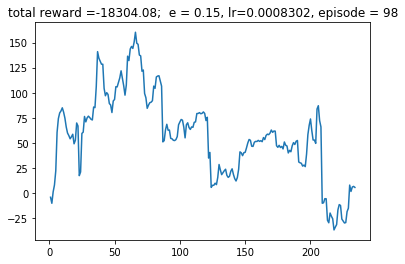

Waiting to train the whole dataset
DONE, lets roll!!
144.751
More than 80 on candle 197
More than 80 on candle 475
More than 80 on candle 1637


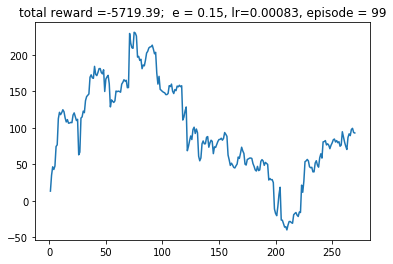

Waiting to train the whole dataset
DONE, lets roll!!
144.659
More than 80 on candle 478
More than 80 on candle 1644


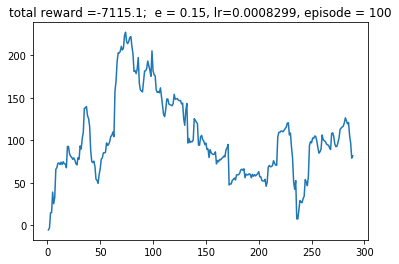

Waiting to train the whole dataset
DONE, lets roll!!
144.675
More than 80 on candle 124
More than 80 on candle 481
More than 80 on candle 1640


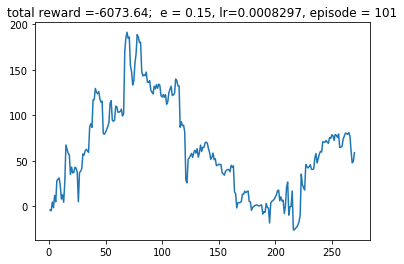

Waiting to train the whole dataset
DONE, lets roll!!
146.435
More than 80 on candle 195
More than 80 on candle 474
More than 80 on candle 1647


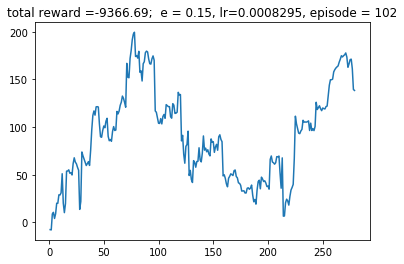

Waiting to train the whole dataset
DONE, lets roll!!
145.139
More than 80 on candle 476
More than 80 on candle 1656


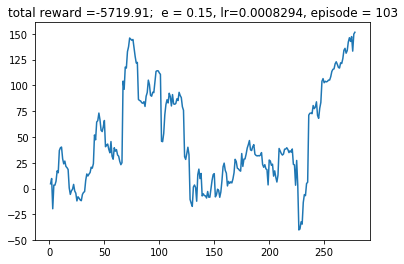

Waiting to train the whole dataset
DONE, lets roll!!
144.737
More than 80 on candle 191
More than 80 on candle 487
More than 80 on candle 1656


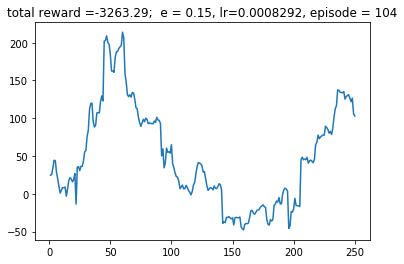

Waiting to train the whole dataset
DONE, lets roll!!
145.161
More than 80 on candle 89
More than 80 on candle 202
More than 80 on candle 488
More than 80 on candle 1647


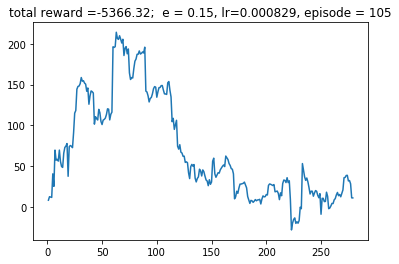

Waiting to train the whole dataset
DONE, lets roll!!
145.94
More than 80 on candle 86
More than 80 on candle 477
More than 80 on candle 1647


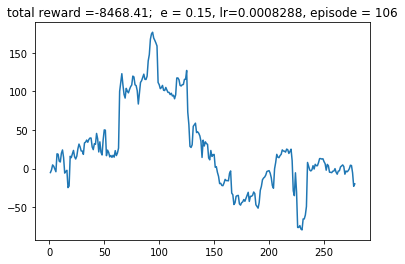

Waiting to train the whole dataset
DONE, lets roll!!
145.133
More than 80 on candle 94
More than 80 on candle 191
More than 80 on candle 487
More than 80 on candle 1641


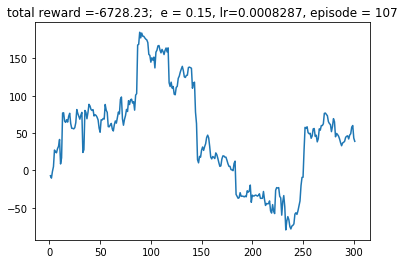

Waiting to train the whole dataset
DONE, lets roll!!
144.991
More than 80 on candle 93
More than 80 on candle 184
More than 80 on candle 1644


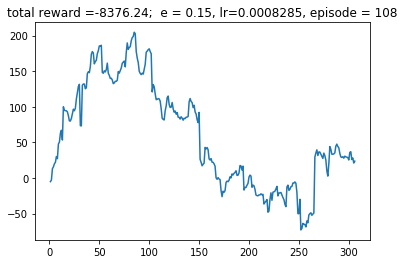

Waiting to train the whole dataset


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 32
agent = DQNAgent(state_size, action_size, batch_size)

# agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > 80 * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than 80 on candle {}'.format(time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(3)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))